# Pembelajaran Mesin: Tugas Besar 1

Kaenova Mahendra Auditama  
IF-43-02  
1301190324  
  
Pada kodingan ini, saya mencoba untuk membuat sebuah model yang akan digunakan untuk membuat cluster pada suatu data. Data yang diberikan merupakan data ketertarikan pelanggan untuk membeli kendaraan baru. Pada akhirnya, saya menggunakan algoritma k-means karena kami diminta untuk membuat model dalam bentuk unsupervised learning
  
  
<sup>\*runs on AI Lab computer</sup>

# Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
import random
import math
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from urllib.request import urlopen
import multiprocessing as mp

# Import Data

In [3]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/raw/kendaraan_train.csv")
df_raw.head()

id Jenis_Kelamin  Umur  SIM  Kode_Daerah  Sudah_Asuransi Umur_Kendaraan  \
0   1        Wanita  30.0  1.0         33.0             1.0      < 1 Tahun   
1   2          Pria  48.0  1.0         39.0             0.0      > 2 Tahun   
2   3           NaN  21.0  1.0         46.0             1.0      < 1 Tahun   
3   4        Wanita  58.0  1.0         48.0             0.0      1-2 Tahun   
4   5          Pria  50.0  1.0         35.0             0.0      > 2 Tahun   

  Kendaraan_Rusak    Premi  Kanal_Penjualan  Lama_Berlangganan  Tertarik  
0           Tidak  28029.0            152.0               97.0         0  
1          Pernah  25800.0             29.0              158.0         0  
2           Tidak  32733.0            160.0              119.0         0  
3           Tidak   2630.0            124.0               63.0         0  
4             NaN  34857.0             88.0              194.0         0

In [4]:
len(df_raw)

285831

# Data Preprocessing

## Drop data yang ada NaN

In [5]:
df_dropna = df_raw.dropna(how="any")
len(df_dropna)

171068

## Drop data Categorical

In [6]:
df_dropna_dropcategorical = df_dropna.drop(axis=1, columns=["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"])
df_dropna_dropcategorical.sample(5)

id  Umur  Kode_Daerah    Premi  Kanal_Penjualan  \
15113    15114  21.0         13.0  30048.0            152.0   
225900  225901  27.0         36.0  29085.0            152.0   
228855  228856  42.0         33.0  31462.0            138.0   
117081  117082  23.0         50.0  32547.0            152.0   
285221  285222  49.0         26.0  34262.0            124.0   

        Lama_Berlangganan  Tertarik  
15113                54.0         0  
225900              199.0         0  
228855              109.0         0  
117081              203.0         0  
285221              298.0         0

## Check Outlier

Text(0.5, 1.0, 'Kode_Daerah')

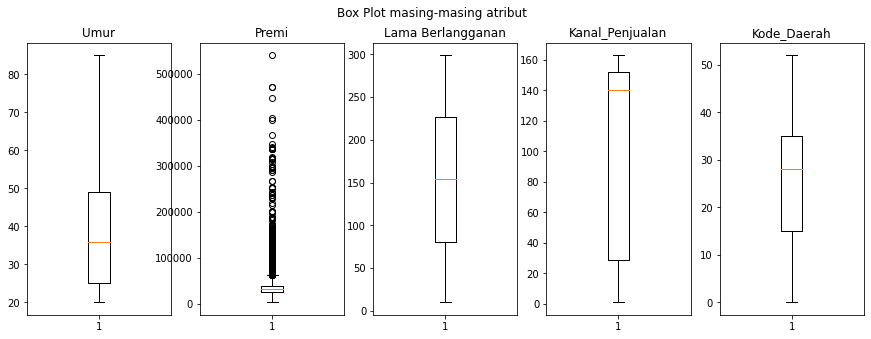

In [7]:
fig, (g1, g2, g3, g4, g5) = plt.subplots(1,5)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(df_dropna_dropcategorical["Umur"])
g1.set_title("Umur")
g2.boxplot(df_dropna_dropcategorical["Premi"])
g2.set_title("Premi")
g3.boxplot(df_dropna_dropcategorical["Lama_Berlangganan"])
g3.set_title("Lama Berlangganan")
g4.boxplot(df_dropna_dropcategorical["Kanal_Penjualan"])
g4.set_title("Kanal_Penjualan")
g5.boxplot(df_dropna_dropcategorical["Kode_Daerah"])
g5.set_title("Kode_Daerah")

## Drop Outlier menggunakan IQR method

In [8]:
describe = df_dropna_dropcategorical.describe()
describe
iqr_premi = float(describe["Premi"].loc["75%"] - describe["Premi"].loc["25%"])
q1_bound = float(describe["Premi"].loc["25%"]) - (iqr_premi * 1.5)
q2_bound = float(describe["Premi"].loc["75%"]) + (iqr_premi * 1.5)
final_df = df_dropna_dropcategorical.copy()
final_df.reset_index(drop=True, inplace=True)
final_df = final_df[(final_df["Premi"] > q1_bound) & (final_df["Premi"] < q2_bound)]
len(final_df)

166396

Text(0.5, 1.0, 'Kode_Daerah')

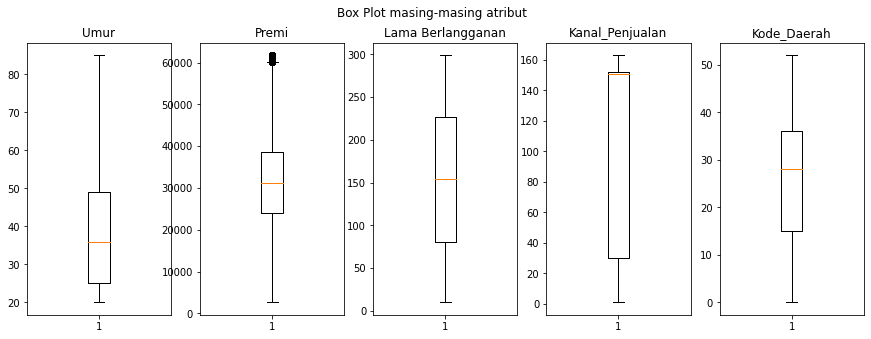

In [9]:
fig, (g1, g2, g3, g4, g5) = plt.subplots(1,5)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(final_df["Umur"])
g1.set_title("Umur")
g2.boxplot(final_df["Premi"])
g2.set_title("Premi")
g3.boxplot(final_df["Lama_Berlangganan"])
g3.set_title("Lama Berlangganan")
g4.boxplot(final_df["Kanal_Penjualan"])
g4.set_title("Kanal_Penjualan")
g5.boxplot(final_df["Kode_Daerah"])
g5.set_title("Kode_Daerah")

## Check Correlation

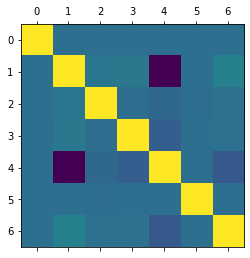

In [10]:
plt.matshow(final_df.corr())
plt.show()

In [11]:
final_df.corr()

id      Umur  Kode_Daerah     Premi  Kanal_Penjualan  \
id                 1.000000  0.002691     0.000597  0.002643        -0.001621   
Umur               0.002691  1.000000     0.044503  0.046519        -0.574807   
Kode_Daerah        0.000597  0.044503     1.000000 -0.004068        -0.044871   
Premi              0.002643  0.046519    -0.004068  1.000000        -0.105819   
Kanal_Penjualan   -0.001621 -0.574807    -0.044871 -0.105819         1.000000   
Lama_Berlangganan  0.001875 -0.001055    -0.003771  0.001831         0.000017   
Tertarik           0.000203  0.108781     0.010484  0.019686        -0.139186   

                   Lama_Berlangganan  Tertarik  
id                          0.001875  0.000203  
Umur                       -0.001055  0.108781  
Kode_Daerah                -0.003771  0.010484  
Premi                       0.001831  0.019686  
Kanal_Penjualan             0.000017 -0.139186  
Lama_Berlangganan           1.000000  0.001819  
Tertarik                    0.001819  1.000000

Korelasi yang "menonjol" pada atribut umur dan kanal_penjualan

# Modelling

In [12]:
class KMeans:
  training_arr = None
  point = None
  inertia = None
  
  def __init__(self, df: pd.DataFrame):
    '''
    Kelas ini digunakan untuk menyiapkan dataframe yang akan ditraining.
    Pastikan kolom bernama id atau sejenis sudah di drop tidak termasuk ke dalam dataframe.
    '''
    print("K-Means akan ditentukan oleh atribut-atribut di bawah ini:")
    print("[", end="")
    for i in range(len(df.columns)):
      print(df.columns[i] + " ", end="")
    print("]", end="\n")
    self.training_arr = df.to_numpy()
    
  def fit_predict(self, k_num:int = 3, max_step:int = 500, conv_threshold: float = 1e-5) -> np.array:
    '''
    Membuat model KMeans dengan K tertentu. Akan mengkembalikan hasil prediksi cluster.
    Poin kluster akan disimpan pada variable point
    '''
    # Setting up cluster arry for every record
    cluster = np.zeros(len(self.training_arr))
    
    # normalize data
    data = self.__normalize_data__(self.training_arr)
    
    # Initialize centroid using KMeans++  
    point = self.__initialize_centroids__(data, k_num)
        
    # Setup convergence and counter
    convergence = False
    step = 0 
        
    while not convergence and (step < max_step):
      initial_point = point
      distance = self.__calculate_distance__(data, point)
      cluster = self.__clustering__(distance)
      new_point = self.__point_nomralization__(data, point, cluster)
      convergence = self.__convergence_check__(initial_point, new_point, conv_threshold)
      
      if convergence:
        point = new_point
        print("It's convergence!")
      else:
        point = new_point
        step += 1
        print("STEP:", step)
      
    
    self.inertia = self.__calculate_inertia__(data, cluster, point)
    self.point = self.__denormalize_point__(point, self.training_arr)
    return cluster
    
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def get_cluster_centroid(self) -> np.array:
    '''
    Fungsi ini digunakan untuk mengambil point
    '''
    if type(self.point) == "NoneType":
      print("Nothing returned, point not initialize. Try using fit_predict first.")
      return
    return self.point
  
  
  def __initialize_centroids__(self, data:np.array, k:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk menginisialisasikan centroid. Menggunakan algoritma k-means++
    referensi membantu: https://www.youtube.com/watch?v=HatwtJSsj5Q
    '''
    def _hitung_data_point_(num_process:int, data:np.array, centoids:np.array, return_dict:dict):
      min_dist = []
      for data_point in data:
        distance_data_point = []
        for point in centroids:
          distance_data_point.append(np.sum(((data_point-point)**2)**0.5) )
        min_dist.append(min(distance_data_point))
      return_dict[num_process] = min_dist
            
    centroids = []
    random.seed(1) # To get same random result for benchmark purposes
    centroids.append( data[random.randrange(0, len(data))] )
    
    for i in range(1, k):
      min_dist = []
      data_split = np.array_split(data, os.cpu_count())
      manager = mp.Manager()
      return_dict = manager.dict()
      processes = [mp.Process(target=_hitung_data_point_, args=(i, data_split[i], centroids, return_dict)) for i in range(len(data_split))]
      for process in processes:
        process.start()
      for process in processes:
        process.join()
      min_dist = [return_dict[i] for i in sorted(return_dict)]
      min_dist = np.concatenate((min_dist))
      
      probcum  = sum(min_dist)
      prob_point = [value / probcum for value in min_dist]
      
      centroids.append(data[np.argmax(prob_point)])
    
    return np.array(centroids)
  
  
  def __clustering__(self, distance: np.array) -> np.array:
    '''
    Fungsi ini akan mengembalikan hasil clustering berdasarkan distance
    '''
    cluster = np.zeros(len(distance))
    for i in range(len(cluster)):
      cluster[i] = np.argmin(distance[i])
    return cluster
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def __calculate_distance__(self, data:np.array, point: np.array) -> np.array:
    '''
    Fungsi ini akan menghitung setiap titik dengan point dan mengkembalikan jarak dari titik ke point
    '''
    # Setup penghitung
    def _hitung_data_point_(num_process:int, data:np.array, point:np.array, return_dict):
      distance = np.zeros((len(data), len(point)))
      for i in range(len(data)):
        current_record = data[i]
        for j in range(len(point)):
          current_point = point[j]
          distance[i][j] = np.sum(((current_record-current_point)**2)**0.5)   
      return_dict[num_process] = distance
      
    # Setup Processor dan bagi data
    data_split = np.array_split(data, os.cpu_count())
    manager = mp.Manager()
    return_dict = manager.dict()
    processes = [mp.Process(target=_hitung_data_point_, args=(i, data_split[i], point, return_dict)) for i in range(len(data_split))]
    
    # Run on all the process
    for process in processes:
      process.start()
    for process in processes:
      process.join()
    distance = [return_dict[i] for i in sorted(return_dict)]
    distance = np.concatenate((distance))
    return distance
  
  def __point_nomralization__(self, data:np.array, point:np.array, cluster:np.array) -> (np.array, np.array):
    '''
    Fungsi ini digunakan untuk menghitung ulang kembali point dengan rata-rata
    '''
    new_point = np.zeros((len(point), len(point[0])))
    counter_array = np.zeros(len(point))
    for i in range(len(cluster)):
      new_point[int(cluster[i])] = new_point[int(cluster[i])] + data[i]
      counter_array[int(cluster[i])] += 1
      
    unique_on_cluster = np.unique(cluster)
    for i in range(len(point)):
      # nan handling
      if i not in unique_on_cluster:
        new_point[i] = point[i]
      else:
        new_point[i] = np.true_divide(new_point[i], counter_array[i])
      
    return new_point
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def __convergence_check__(self, points1: np.array, points2:np.array, threshold: float) -> bool:
    '''
    Fungsi ini untuk mengecek convergence berdasarkan threshold yang dibuat.
    titik cluster pertama akan dibandingkan dengan titik cluster kedua.
    note: maybe i should use euclediance distance insted of menghitung satu-satu
    '''
    local_convergence = False
    normalize_threshold_positive, normalize_threshold_negative  = 1 + threshold, 1 - threshold
    points_counter = 0
    center = np.zeros(len(points1[0]))
    for i in range(len(points1)):
      current_first_point, current_second_point = points1[i], points2[i]
      distance_first_point, distance_second_point = np.sum(((current_first_point - center)**2)**0.5), np.sum(((current_second_point - center)**2)**0.5)
      distance_threshold_positive = distance_first_point * normalize_threshold_positive
      distance_threshold_negative = distance_first_point * normalize_threshold_negative
      if distance_threshold_positive > distance_second_point and distance_threshold_negative < distance_second_point:
        points_counter += 1
    
    if points_counter == len(points1):
      local_convergence = True
    
    return local_convergence
  
  def __calculate_inertia__(self, data:np.array, cluster:np.array, points:np.array) -> np.array:
    '''
    K-Means: Inertia
    Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.
    ref: https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819
    '''
    inertia = 0
    for i in range(len(data)):
      inertia += np.sum(((data[i]-points[int(cluster[i])])**2)**0.5)**2      
    return inertia
  
  def __normalize_data__(self, data:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk menormalisasikan data dengan menggunakan min-max scaling. Sehingga data berjenis dan bersatuan apapun data diproses dengan baik.
    '''
    data = data.copy()
    for i in range(len(data[0])):
      col_arr = data[:,i]
      minmax = MinMaxScaler()
      normalize = minmax.fit_transform(col_arr.reshape(-1,1)).reshape(1,-1)
      data[:, i] = normalize[0]
      
    return data
  
  def __denormalize_point__(self, data:np.array, original_data:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk mendenormalisasikan point-point yang sudah dihitung menggunakan data yang ternormalisasi
    '''
    for i in range(len(data[0])):
      col_arr = data[:,i]
      col_arr_ori = original_data[:, i]
      
      minimums = min(col_arr_ori)
      maximums = max(col_arr_ori)
      for j in range(len(col_arr)):
        col_arr[j] = ((col_arr[j]*(maximums - minimums)) + minimums)
      data[:, i] = col_arr
    return data

# Eksperimen Utama

In [13]:
df_training = final_df.copy()
df_training.set_index("id", inplace=True)
df_labels = df_training["Tertarik"]
df_training.drop(columns="Tertarik", axis=1, inplace=True)

In [14]:
df_training.head()

Umur  Kode_Daerah    Premi  Kanal_Penjualan  Lama_Berlangganan
id                                                                
1   30.0         33.0  28029.0            152.0               97.0
2   48.0         39.0  25800.0             29.0              158.0
4   58.0         48.0   2630.0            124.0               63.0
6   21.0         35.0  22735.0            152.0              171.0
9   20.0          8.0  30786.0            160.0               31.0

In [15]:
# len(df_training)

In [16]:
# df_training.to_csv("../data/processed/kendaraan_train_processed.csv")
df_training = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/processed/kendaraan_train_processed.csv")
df_training

id  Umur  Kode_Daerah    Premi  Kanal_Penjualan  Lama_Berlangganan
0            1  30.0         33.0  28029.0            152.0               97.0
1            2  48.0         39.0  25800.0             29.0              158.0
2            4  58.0         48.0   2630.0            124.0               63.0
3            6  21.0         35.0  22735.0            152.0              171.0
4            9  20.0          8.0  30786.0            160.0               31.0
...        ...   ...          ...      ...              ...                ...
166391  285827  23.0          4.0  25988.0            152.0              217.0
166392  285828  21.0         46.0  44686.0            152.0               50.0
166393  285829  23.0         50.0  49751.0            152.0              226.0
166394  285830  68.0          7.0  30503.0            124.0              270.0
166395  285831  45.0         28.0  36480.0             26.0               44.0

[166396 rows x 6 columns]

## 2 Atribut (Kanal Penjualan dan Umur)

In [17]:
# No need to train again, i've already save the clusters
# But if you want to try the training part, just uncomment this

MAX_K = 15

import pandas as pd

data_run_history = {
  "data" : "2 Data Kanal Penjualan dan Umur", 
  "k_runs" : {}
}

for i in range(1, MAX_K+1):
  print("==== K:", i, "====" )
  run_data = {
    "points" : None,
    "cluster" : None,
    "inertia" : None
  }
  
  model = KMeans(df_training.filter(items=["Umur","Kanal_Penjualan"]))
  run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
  run_data["inertia"] = model.inertia
  run_data["points"] = model.point
  data_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
It's convergence!
==== K: 5 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
It's convergence!
==== K: 6 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Kanal_Penjualan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
It's convergence!
==== K: 7 ====
K-Means akan ditentukan oleh atri

In [38]:
## Jika melakukan training, untuk save variable training, uncomment cell ini
# FILE_NAME = "2data_umur_kanal_15k.pckl"
# f = open('./saved_vars/'+FILE_NAME, 'wb')
# pickle.dump(data_run_history, f)
# f.close()

In [3]:
# # Jika melakukan training, anda dapat comment cell ini, karena hanya akan me-load training history untuk laporan
# data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/notebooks/saved_vars/2data_umur_kanal_15k.pckl"))
# data_run_history

{'data': '2 Data Kanal Penjualan dan Umur',
 'k_runs': {1: {'points': array([[ 38.66680689, 112.7540626 ]]),
   'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 27866.962611680417},
  2: {'points': array([[ 34.20328834, 144.21263804],
          [ 51.02727314,  25.63833643]]),
   'cluster': array([0., 1., 0., ..., 0., 0., 1.]),
   'inertia': 8318.173194107347},
  3: {'points': array([[ 50.99709124,  25.42822407],
          [ 25.95379782, 151.1485044 ],
          [ 51.3202333 , 129.712158  ]]),
   'cluster': array([1., 0., 2., ..., 1., 2., 0.]),
   'inertia': 3760.6523522718267},
  4: {'points': array([[ 51.31749887, 129.73040517],
          [ 42.3052652 ,  25.56403407],
          [ 63.34584937,  25.28130841],
          [ 25.95379782, 151.1485044 ]]),
   'cluster': array([3., 1., 0., ..., 3., 0., 1.]),
   'inertia': 2642.6635598516177},
  5: {'points': array([[ 51.31347994, 129.73834093],
          [ 34.19620117,  25.23451327],
          [ 67.54458838,  25.14977016],
      

Searching best k value with Elbow Method

Text(0.5, 1.0, 'Performance on K Values (2 Data)')

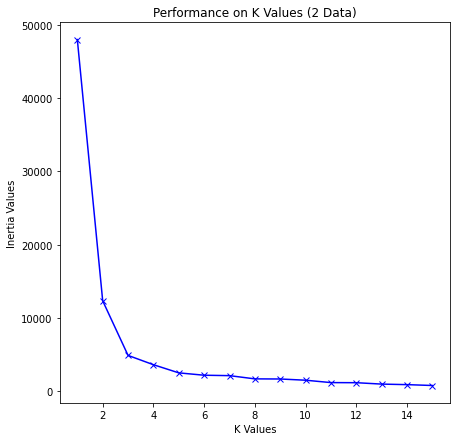

In [18]:
plt.figure(figsize=(7,7))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values (2 Data)")

Best K = 3

In [19]:
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["id", "Umur", "Kanal_Penjualan"])
df_processing["Cluster"] = data_run_history["k_runs"][3]["cluster"]
df_processing

id  Umur  Kanal_Penjualan  Cluster
0            1  30.0            152.0      0.0
1            2  48.0             29.0      1.0
2            4  58.0            124.0      2.0
3            6  21.0            152.0      0.0
4            9  20.0            160.0      0.0
...        ...   ...              ...      ...
166391  285827  23.0            152.0      0.0
166392  285828  21.0            152.0      0.0
166393  285829  23.0            152.0      0.0
166394  285830  68.0            124.0      2.0
166395  285831  45.0             26.0      1.0

[166396 rows x 4 columns]

Silhoutte Score

In [20]:
X = df_processing.filter(items=["Umur", "Kanal_Penjualan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
sil_sample

array([0.78213245, 0.86748122, 0.63640056, ..., 0.85204021, 0.57305278,
       0.87310321])

rata-rata silhouette cluster 0 : 0.7556022696722964
rata-rata silhouette cluster 1 : 0.8237917650833451
rata-rata silhouette cluster 2 : 0.47302599775615417
rata-rata silhouette : 0.6841400108372652


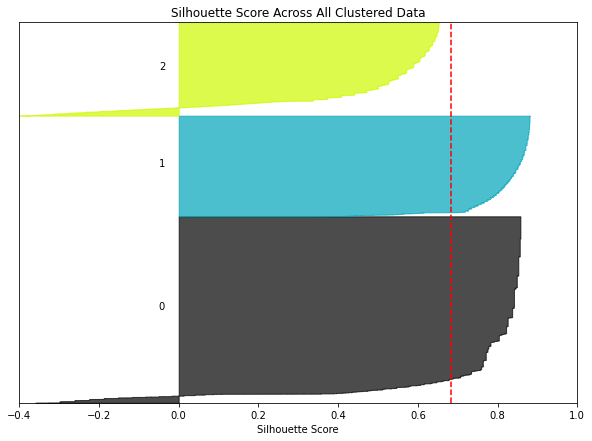

In [21]:
# ref : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import statistics
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")

Text(0.5, 1.0, 'Scatter Plot Clustering')

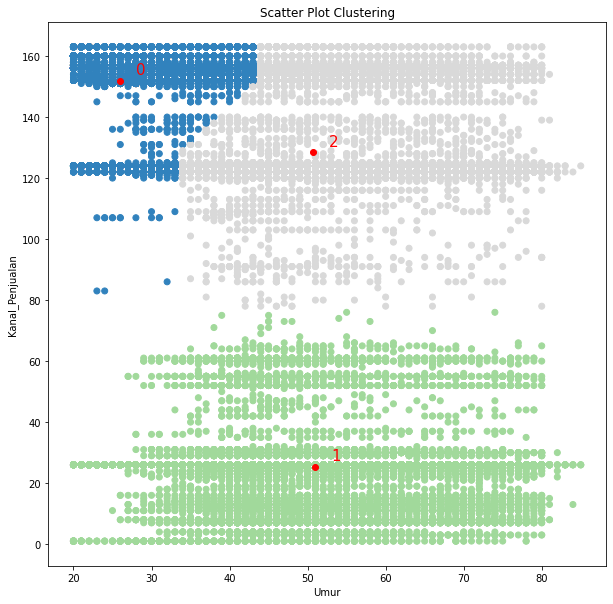

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))
ax.scatter(df_processing["Umur"], df_processing["Kanal_Penjualan"], c=df_processing["Cluster"], cmap="tab20c")
ax.scatter(data_run_history["k_runs"][3]["points"][:, 0], data_run_history["k_runs"][3]["points"][:, 1], color="red")
for i in range(len(data_run_history["k_runs"][3]["points"])):
    ax.text(data_run_history["k_runs"][3]["points"][i, 0]+2, data_run_history["k_runs"][3]["points"][i, 1]+2, str(i), color="red", fontsize = 15)
ax.set_xlabel("Umur")
ax.set_ylabel("Kanal_Penjualan")
ax.set_title("Scatter Plot Clustering")